In [1]:
import numpy as np
import jax.numpy as jnp
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt
from jax import jacfwd

In [2]:
# def measurement(v1, v2):
#     rg = jnp.linalg.norm(v1 - v2)
#     br = (v2[1] - v1[1]) / rg + (v2[0] - v1[0]) / rg
#     return jnp.array([rg, br])

def measurement(v1, v2):
    return v2 - v1 

# def measurement(v1, v2):
#     return v2 ** 2 - v1

print('test measurement: ', measurement(np.array([0.,0.]), np.array([1.,2.])))

test measurement:  [1. 2.]


In [3]:
measurement_jac_v1 = jacfwd(measurement, argnums=0)
measurement_jac_v2 = jacfwd(measurement, argnums=1)
print('test measurement jacobian:')
print(measurement_jac_v1(np.array([0.,0.]), np.array([1.,2.])))
print(measurement_jac_v2(np.array([0.,0.]), np.array([1.,2.])))

test measurement jacobian:
[[-1. -0.]
 [-0. -1.]]
[[1. 0.]
 [0. 1.]]


In [4]:
nodes_gt = np.array([
    [0., 0.],
    [1., 0.],
    [2., 0.],
    [1., 1.],
    [2., 1.],
])

In [5]:
import time
np.random.seed(int(time.time()*1000) % 1000)
noise = mvn.rvs(mean=np.zeros(2), cov=np.diag([0.2, 0.2]), size=5)
noise = np.clip(noise, a_min=-0.3, a_max=0.3)
nodes_ns = nodes_gt + noise

In [6]:
edges = np.array([
    [0, 1],
    [0, 3],
    [1, 3],
    [1, 2],
    [2, 4]
], dtype=int)

In [7]:
def config_figure(title=None):
    fig, ax = plt.subplots(1, 1, figsize=(8., 6.))
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 1.5)
    if title is not None:
        ax.set_title(title, fontsize=15)
    return fig, ax

In [8]:
def plot_graph(nodes, edges, title=None):
    fig, ax = config_figure(title)
    
    for edge in edges:
        n1 = nodes[edge[0]]
        n2 = nodes[edge[1]]
        ax.plot([n1[0], n2[0]], [n1[1], n2[1]], color='C1', linewidth=5)
    for i in range(nodes.shape[0]):
        node = nodes[i]
        ax.plot(node[0], node[1], c='C0', linestyle='', marker='o', markersize=20)
        ax.text(node[0]+0.05, node[1]-0.12, 'node{}'.format(i), fontsize=12, fontweight='heavy', color='C0')
    
    plt.show()

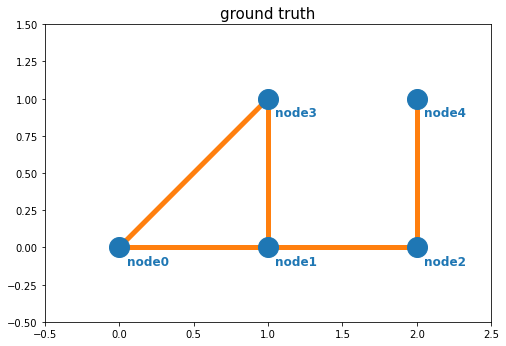

In [9]:
plot_graph(nodes_gt, edges, 'ground truth')

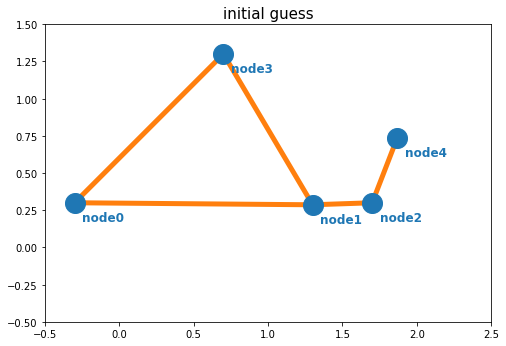

In [10]:
plot_graph(nodes_ns, edges, 'initial guess')

In [11]:
obsv_gt = np.array([
    measurement(nodes_gt[edge[0]], nodes_gt[edge[1]])
    for edge in edges
])
obsv_gt

array([[1., 0.],
       [1., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [12]:
noise = mvn.rvs(mean=np.zeros(2), cov=np.diag([0.001, 0.001]), size=5)
noise = np.clip(noise, a_min=-0.05, a_max=0.05)
obsv_ns = obsv_gt + noise
obsv_ns[:,1] = np.clip(obsv_ns[:,1], a_min=-1., a_max=1.)
obsv_ns

array([[ 0.95592648,  0.03491723],
       [ 0.97051681,  0.97017477],
       [ 0.0138067 ,  1.        ],
       [ 1.02275364,  0.00277212],
       [-0.04182898,  1.        ]])

In [49]:
def binary_factor(v1, v2, obsv):
    sim_obsv = np.array(measurement(v1, v2))
    diff = sim_obsv - obsv
    return (diff[0]**2 + diff[1]**2) #/ 0.01

binary_factor(nodes_ns[0], nodes_ns[1], obsv_ns[0])

0.41718453588420445

In [50]:
def objective(nodes, edges, obsv_list):
    obj = 0.
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        obsv = obsv_list[i]
        obj += binary_factor(v1, v2, obsv) / 2
    return obj
    
objective(nodes_ns, edges, obsv_ns)

0.7735655763078342

In [15]:
def objective_jac(nodes, edges, obsv_list):
    jac = np.zeros_like(nodes)
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        obsv = obsv_list[i]
        diff = measurement(v1, v2) - obsv
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2) 
        jac[ed[0]] += jac_v1 @ diff
        jac[ed[1]] += jac_v2 @ diff
    return jac

In [16]:
objective_jac(nodes_gt, edges, obsv_ns)

array([[-0.07355671,  0.005092  ],
       [ 0.08063386, -0.03214511],
       [-0.06458262, -0.00277212],
       [ 0.01567649,  0.02982523],
       [ 0.04182898,  0.        ]])

In [17]:
def fg_armijo(x, p, f, df):
    c = 1e-04
    a = 1.0
    rho = 0.5
    for i in range(10):
        df_sum = 0.
        df_k = df(x)
        for j in range(p.shape[0]):
            df_sum += p[j][0]*df_k[j][0] + p[j][1]*df_k[j][1]
        gap = f(x + a*p) - f(x) - c*a*df_sum
        #print('armijo {} gap: {}'.format(i, gap))
        if gap < 0.:
            return a
        else:
            a *= rho
    return 0.0

In [18]:
nodes_p = objective_jac(nodes_gt, edges, obsv_ns)
step_len = fg_armijo(nodes_gt, -nodes_p, 
                     lambda nodes: objective(nodes, edges, obsv_ns), 
                     lambda nodes: objective_jac(nodes, edges, obsv_ns))

In [19]:
def fg_gradient_descent(nodes, edges, obsv_list):
    nodes_k = nodes.copy()
    for i in range(50):
        obj_k = objective(nodes_k, edges, obsv_list)
        nodes_p = objective_jac(nodes_k, edges, obsv_list)
        nodes_p_norm = np.linalg.norm(nodes_p)
        
#         if(nodes_p_norm < 1e-06):
#             print('converged.')
#             break
        
        step_len = fg_armijo(nodes_k, -nodes_p, 
                             lambda nodes: objective(nodes, edges, obsv_list), 
                             lambda nodes: objective_jac(nodes, edges, obsv_list))
        
        nodes_k -= nodes_p * step_len
        obj_knew = objective(nodes_k, edges, obsv_list)
        
        drop = obj_k - obj_knew
        print('iteration {}: {}, {}'.format(i, obj_k, drop))
        if drop < 1e-04:
            print('converged.')
            break
        
    return nodes_k

iteration 0: 0.7735655763078342, 0.013564786280858221
iteration 1: 0.760000790026976, 0.7391721404900614
iteration 2: 0.020828649536914535, 0.001746545689742949
iteration 3: 0.019082103847171586, 0.00035778712784353267
iteration 4: 0.018724316719328053, 0.016229267346185225
iteration 5: 0.002495049373142827, 0.0010946300467127533
iteration 6: 0.0014004193264300737, 0.0001417172662361761
iteration 7: 0.0012587020601938976, 4.238258771595673e-05
converged.


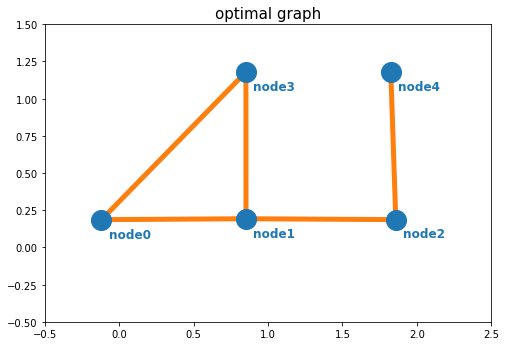

In [20]:
nodes_opt = fg_gradient_descent(nodes_ns, edges, obsv_ns)
plot_graph(nodes_opt, edges, 'optimal graph')

In [21]:
def linearized_objective_jac(increments, nodes, edges, obsv_list):
    jac = np.zeros_like(nodes)
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        icrmt1 = increments[ed[0]]
        icrmt2 = increments[ed[1]]
        obsv = obsv_list[i]
        
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2)
        c = measurement(v1, v2) - obsv
        diff1 = jac_v1 @ icrmt1 + jac_v2 @ icrmt2 + c
        diff2 = jac_v1 @ icrmt1 + jac_v2 @ icrmt2 + c
        
        jac[ed[0]] += jac_v1 @ diff1
        jac[ed[1]] += jac_v2 @ diff2
        
    return jac

In [22]:
increments_test = np.ones_like(nodes_gt) * 0.0
print(objective_jac(nodes_ns, edges, obsv_ns), end='\n\n')
print(linearized_objective_jac(increments_test, nodes_ns, edges, obsv_ns))

[[-0.67355675  0.01869114]
 [ 1.88063383 -0.07294251]
 [-0.83281094  0.5757879 ]
 [-0.58432351  0.04342436]
 [ 0.21005733 -0.56496089]]

[[-0.67355675  0.01869114]
 [ 1.88063383 -0.07294251]
 [-0.83281094  0.5757879 ]
 [-0.58432353  0.04342436]
 [ 0.21005733 -0.5649609 ]]


In [23]:
def linearized_objective_fullmatrix(increments, nodes, edges, obsv_list):
    J = np.zeros((obsv_list.ravel().shape[0], nodes.ravel().shape[0]))
    y = np.zeros(obsv_list.ravel().shape[0])
    
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        icrmt1 = increments[ed[0]]
        icrmt2 = increments[ed[1]]
        obsv = obsv_list[i]
        
        diff = measurement(v1, v2) - obsv
        y[i*2 : i*2+2] = diff
        
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2)
        J[i*2][ed[0]*2 : ed[0]*2+2] = jac_v1[:,0]
        J[i*2][ed[1]*2 : ed[1]*2+2] = jac_v2[:,0]
        J[i*2+1][ed[0]*2 : ed[0]*2+2] = jac_v1[:,1]
        J[i*2+1][ed[1]*2 : ed[1]*2+2] = jac_v2[:,1]
    
    return np.linalg.norm(J @ increments.ravel() - y) ** 2 / 2

In [24]:
increments_test = np.random.normal(size=nodes_ns.shape) * 0.01
print(linearized_objective_fullmatrix(increments_test, nodes_ns, edges, obsv_ns))
print(objective(nodes_ns+increments_test, edges, obsv_ns))

0.7499222629133029
0.7997983300688258


In [25]:
def linearized_objective_jac_fullmatrix(increments, nodes, edges, obsv_list):
    J = np.zeros((obsv_list.ravel().shape[0], nodes.ravel().shape[0]))
    y = np.zeros(obsv_list.ravel().shape[0])
    
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        icrmt1 = increments[ed[0]]
        icrmt2 = increments[ed[1]]
        obsv = obsv_list[i]
        
        diff = measurement(v1, v2) - obsv
        y[i*2 : i*2+2] = diff
        
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2)
        J[i*2][ed[0]*2 : ed[0]*2+2] = jac_v1[:,0]
        J[i*2][ed[1]*2 : ed[1]*2+2] = jac_v2[:,0]
        J[i*2+1][ed[0]*2 : ed[0]*2+2] = jac_v1[:,1]
        J[i*2+1][ed[1]*2 : ed[1]*2+2] = jac_v2[:,1]
    
    return J, y, J.T @ (J @ increments.ravel() + y)

[[-0.67355671  0.01869114]
 [ 1.88063386 -0.07294251]
 [-0.83281097  0.57578791]
 [-0.58432351  0.04342436]
 [ 0.21005733 -0.56496089]]


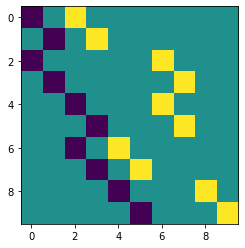

In [51]:
increments_test = np.ones_like(nodes_gt) * 0.0
J, y, obj_jac = linearized_objective_jac_fullmatrix(increments_test, nodes_ns, edges, obsv_ns)
print(obj_jac.reshape(-1,2))
plt.imshow(J)

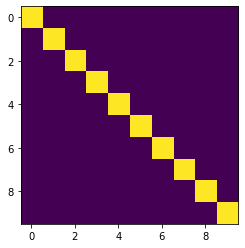

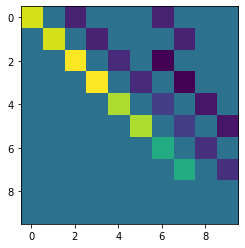

In [52]:
Q, R = np.linalg.qr(J)
plt.imshow(Q.T @ Q)
plt.show()
plt.imshow(R)
plt.show()

In [27]:
def fg_gauss_newton(nodes, edges, obsv_list):
    nodes_k = nodes.copy()
    for i in range(50):
        obj_k = objective(nodes_k, edges, obsv_list)
        
        J, y, obj_jac = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_k), nodes_k, edges, obsv_list)
        #nodes_p = np.linalg.inv(J.T @ J) @ (-J.T @ y)
        nodes_p = np.linalg.solve(J.T @ J, -J.T @ y) # more stable
        nodes_p = np.array(nodes_p).reshape(-1,2)
        
        nodes_p_norm = np.linalg.norm(nodes_p)
        
        step_len = fg_armijo(nodes_k, nodes_p, 
                             lambda nodes: objective(nodes, edges, obsv_list), 
                             lambda nodes: objective_jac(nodes, edges, obsv_list))
        
        nodes_k += nodes_p * step_len
        obj_knew = objective(nodes_k, edges, obsv_list)
        
        drop = obj_k - obj_knew
        print('iteration {}: {}, {}'.format(i, obj_k, drop))
        if drop < 1e-04:
            print('converged.')
            break
        
    return nodes_k

iteration 0: 0.7735655763078342, 0.7728668764383945
iteration 1: 0.0006986998694397216, 7.589415207398531e-19
converged.


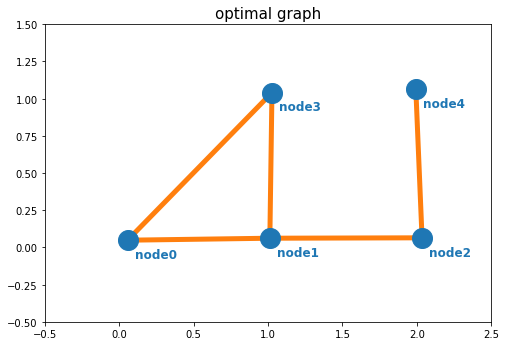

In [28]:
nodes_opt_gn = fg_gauss_newton(nodes_ns, edges, obsv_ns)
plot_graph(nodes_opt_gn, edges, 'optimal graph')

In [29]:
def back_substitute(A, b): # A is square upper-triangular
    x = np.zeros_like(b)
    for i in range(x.shape[0]):
        curr_row = x.shape[0] - i - 1
        val = b[curr_row]
        #print(val)
        for j in range(i):
            prev_col = x.shape[0] - j - 1
            val -= x[prev_col] * A[curr_row, prev_col]
            #print(j, val)
        #print(val, A[curr_row, curr_row], val / A[curr_row, curr_row])
        if A[curr_row, curr_row] == 0.:
            x[curr_row] = 0.
        else:
            x[curr_row] = val / A[curr_row, curr_row]
    return x

In [30]:
A_test = np.array([[2, -4, 6], [0, 2, -2], [0, 0, 3]], dtype=float)
b_test = np.array([8, 1, 9], dtype=float)
x_test = back_substitute(A_test, b_test)
print(x_test)

[2.  3.5 3. ]


In [31]:
def fg_gauss_newton_qr(nodes, edges, obsv_list):
    nodes_k = nodes.copy()
    for i in range(50):
        obj_k = objective(nodes_k, edges, obsv_list)
        
        J, y, _ = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_k), nodes_k, edges, obsv_list)
        
        Q, R = np.linalg.qr(J, 'reduced')
        plt.imshow(R)
        plt.show()
        nodes_p = back_substitute(R, -Q.T@y)
        
        #nodes_p = np.linalg.inv(J.T @ J) @ (-J.T @ y)
        #nodes_p = np.linalg.solve(J.T @ J, -J.T @ y) # more stable
        nodes_p = np.array(nodes_p).reshape(-1,2)
        
        nodes_p_norm = np.linalg.norm(nodes_p)
        
        step_len = fg_armijo(nodes_k, nodes_p, 
                             lambda nodes: objective(nodes, edges, obsv_list), 
                             lambda nodes: objective_jac(nodes, edges, obsv_list))
        
        nodes_k += nodes_p * step_len
        obj_knew = objective(nodes_k, edges, obsv_list)
        
        drop = obj_k - obj_knew
        print('iteration {}: {}, {}'.format(i, obj_k, drop))
        if drop < 1e-04:
            print('converged.')
            break
        
    return nodes_k

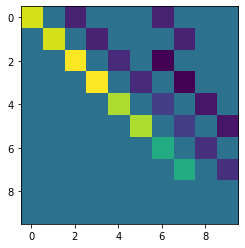

iteration 0: 0.7735655763078342, 0.7728668764383945


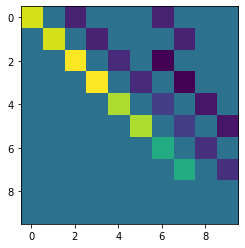

iteration 1: 0.0006986998694397211, 0.0
converged.


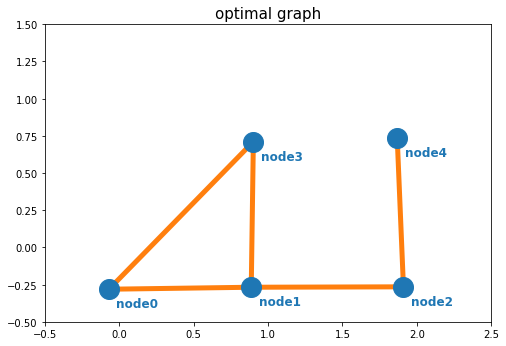

In [32]:
nodes_opt_gn = fg_gauss_newton_qr(nodes_ns, edges, obsv_ns)
plot_graph(nodes_opt_gn, edges, 'optimal graph')

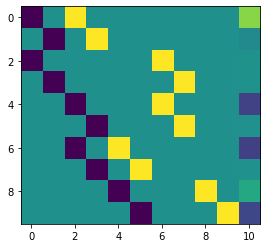

In [33]:
J, y, _ = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_ns), nodes_ns, edges, obsv_ns)
plt.imshow(np.concatenate((J, y[:,np.newaxis]), axis=1))

In [34]:
toy_mat = np.array([
    [-1., 1., 0., y[0]],
    [-1., 0., 1., y[1]]
])
toy_mat

array([[-1.        ,  1.        ,  0.        ,  0.64407352],
       [-1.        ,  0.        ,  1.        , -0.04851636]])

In [35]:
q, r = np.linalg.qr(toy_mat)
print(q)
print(r)
print(q @ r)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[[ 1.41421356 -0.70710678 -0.70710678 -0.4211225 ]
 [ 0.         -0.70710678  0.70710678 -0.489735  ]]
[[-1.00000000e+00  1.00000000e+00 -1.33393446e-16  6.44073519e-01]
 [-1.00000000e+00 -1.33393446e-16  1.00000000e+00 -4.85163629e-02]]


In [36]:
e1 = np.sqrt(2)/2 * -np.ones(2)
e2 = np.sqrt(2)/2 * np.array([1., -1.])
q = np.array([e1, e2]).T
q

array([[-0.70710678,  0.70710678],
       [-0.70710678, -0.70710678]])

In [37]:
r = np.array([
    [q[:,0]@toy_mat[:,0], q[:,0]@toy_mat[:,1], q[:,0]@toy_mat[:,2], q[:,0]@toy_mat[:,3]],
    [                  0, q[:,1]@toy_mat[:,1], q[:,1]@toy_mat[:,2], q[:,1]@toy_mat[:,3]],
])
r

array([[ 1.41421356, -0.70710678, -0.70710678, -0.4211225 ],
       [ 0.        ,  0.70710678, -0.70710678,  0.489735  ]])

In [38]:
q @ r

array([[-1.00000000e+00,  1.00000000e+00,  4.26642159e-17,
         6.44073519e-01],
       [-1.00000000e+00,  4.26642159e-17,  1.00000000e+00,
        -4.85163629e-02]])

In [39]:
def gram_schmit(mat): # assume rows < cols
    rows = mat.shape[0]
    cols = mat.shape[1]
    
    q = np.zeros((rows, rows))
    r = np.zeros((rows, cols))
    u = np.zeros((rows, cols))
    
    for i in range(rows):
        ai = mat[:,i].copy()
        ui = ai
        for j in range(i):
            uj = u[:,j]
            temp = uj * float(uj@ai) / float(uj@uj)
            ui -= temp
        u[:,i] = ui
        ei = ui / np.linalg.norm(ui)
        q[:,i] = ei
        
    for i in range(rows):
        for j in range(cols):
            if j < i:
                r[i,j] = 0.
            else:
                r[i,j] = q[:,i] @ mat[:,j]
    
    return q, r

In [40]:
toy_mat = np.array([
    [-1., 1., 0., y[0]],
    [-1., 0., 1., y[1]]
])

q, r = gram_schmit(toy_mat)
print(q)
print(r)
print(toy_mat - q @ r)

[[-0.70710678  0.70710678]
 [-0.70710678 -0.70710678]]
[[ 1.41421356 -0.70710678 -0.70710678 -0.4211225 ]
 [ 0.          0.70710678 -0.70710678  0.489735  ]]
[[-2.22044605e-16  2.22044605e-16  2.23711432e-17  1.11022302e-16]
 [-2.22044605e-16  2.23711432e-17  2.22044605e-16 -6.93889390e-18]]


In [41]:
def extract_mat(J, index):
    row_index = []
    for i in index:
        for j in range(len(J[i])):
            elmt = J[i][j]
            if elmt != 0:
                row_index.append(j)
    row_index = np.unique(row_index)
    
    mat = []
    for i in index:
        row = J[i][row_index]
        mat.append(row)
    
    return np.array(mat), row_index

In [42]:
def extend_row(vec, row_index, full_len):
    ret = np.zeros(full_len)
    for i in range(full_len):
        for j in range(len(row_index)):
            elmt = row_index[j]
            if i == elmt:
                ret[i] = vec[j]
    return ret

extend_row([-1, 1, 1], [0, 2, 4], 10)

array([-1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [43]:
def remove_rows_cols(mat, rows, cols):
    row_index = []
    for i in range(mat.shape[0]):
        if i not in rows:
            row_index.append(i)
    
    col_index = []
    for i in range(mat.shape[1]):
        if i not in cols:
            col_index.append(i)
            
#     print(row_index)
#     print(col_index)
#     print(mat[row_index])
    ret = mat[row_index] 
    ret = ret[:, col_index]
    return ret

remove_rows_cols(np.arange(24).reshape(4, 6), [0], [1, 2])

array([[ 6,  9, 10, 11],
       [12, 15, 16, 17],
       [18, 21, 22, 23]])

In [44]:
def variable_elimination(J, y):
    Jk = J.copy()
    yk = y.copy()
    
    upper_tria_mat = []
    other_side = []
    new_y = []
    
    it = 0
    while Jk.shape[0] > 1:
#         print('\n it: ', it)
        
#         plt.imshow(Jk)
#         plt.show()
        
        curr_col = Jk[:,0]
        index = curr_col.nonzero()[0]
#         print('index: ', index)
        
        it += 1
        if it > J.shape[0]:
            break
        
        sub_J, row_index = extract_mat(J, index)
        sub_mat = np.concatenate((sub_J, yk[index][:,np.newaxis]), axis=1)
#         print(sub_mat)
        
        q, r = gram_schmit(sub_mat)
        upper_tria_mat.append(extend_row(r[0], np.array(row_index)+it-1, 10))
        other_side.append((q.T @ yk[index])[0])
#         print(q)
#         print(r)
        
        Jk_new = remove_rows_cols(Jk, index, [0])
        yk_new = np.delete(yk, index)
        
        attached_rows = []
        attached_y = (q.T @ yk[index])[1:]
        for i in range(r.shape[0]-1):
            attached_rows.append(extend_row(r[i+1], row_index, 10)[it:])
        attached_rows = np.array(attached_rows)
        
        if len(attached_rows) > 0:
            Jk = np.concatenate((Jk_new, attached_rows), axis=0)
#         print(Jk.shape)
        yk = np.concatenate((yk_new, attached_y))
#         print(yk.shape)
    

    upper_tria_mat = np.array(upper_tria_mat)
    other_side = np.array(other_side)
#     print(upper_tria_mat.shape, other_side.shape)
    
    plt.imshow(upper_tria_mat)
    plt.show()
    
    return upper_tria_mat, other_side

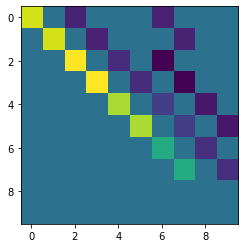

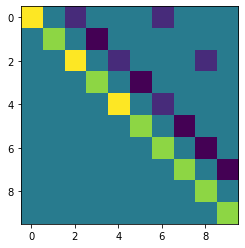

In [45]:
J, y, _ = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_ns), nodes_ns, edges, obsv_ns)
Q, R = gram_schmit(J)
plt.imshow(R)
plt.show()
J, y = variable_elimination(J, y)

In [46]:
def fg_gauss_newton_vl(nodes, edges, obsv_list):
    nodes_k = nodes.copy()
    for i in range(50):
        obj_k = objective(nodes_k, edges, obsv_list)
        
        J, y, _ = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_k), nodes_k, edges, obsv_list)
        
#         Q, R = np.linalg.qr(J, 'reduced')
        Q, R = gram_schmit(J)
        plt.imshow(R)
        plt.show()
        nodes_p = back_substitute(R, -Q.T@y)
        
        #nodes_p = np.linalg.inv(J.T @ J) @ (-J.T @ y)
        #nodes_p = np.linalg.solve(J.T @ J, -J.T @ y) # more stable
        nodes_p = np.array(nodes_p).reshape(-1,2)
        
        nodes_p_norm = np.linalg.norm(nodes_p)
        
        step_len = fg_armijo(nodes_k, nodes_p, 
                             lambda nodes: objective(nodes, edges, obsv_list), 
                             lambda nodes: objective_jac(nodes, edges, obsv_list))
        
        nodes_k += nodes_p * step_len
        obj_knew = objective(nodes_k, edges, obsv_list)
        
        drop = obj_k - obj_knew
        print('iteration {}: {}, {}'.format(i, obj_k, drop))
        if drop < 1e-04:
            print('converged.')
            break
        
    return nodes_k

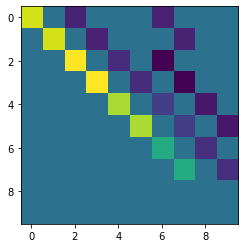

iteration 0: 0.7735655763078342, 0.7728668764383945


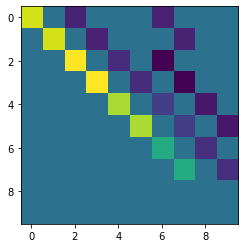

iteration 1: 0.0006986998694397234, 3.577867169202165e-18
converged.


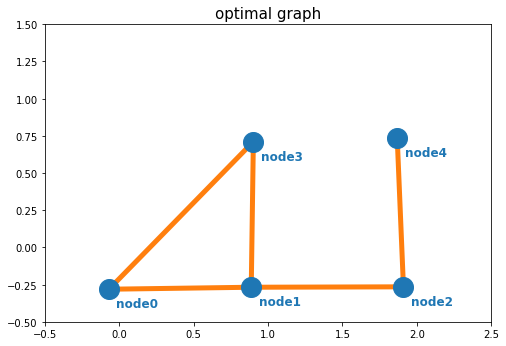

In [47]:
nodes_opt_gn = fg_gauss_newton_vl(nodes_ns, edges, obsv_ns)
plot_graph(nodes_opt_gn, edges, 'optimal graph')

In [48]:
# def variable_elimination(J_, y_):
#     J = J_.copy()
#     y = y_.copy()
#     full_mat = np.concatenate((J, y[:,np.newaxis]), axis=1)
    
#     for i in range(J.shape[1]): # number of states
#         plt.imshow(J)
#         plt.show()
        
#         separator = []
#         rows = []
#         for j in range(J.shape[0]):
#             row = J[j]
#             if row[i] != 0:
#                 rows.append(j)
#                 for k in range(row.shape[0]):
#                     if row[k] != 0. and i != k:
#                         separator.append(k)
        
#         separator_with_node = np.sort([i] + separator)
#         separator = np.unique(separator)
#         separator_with_node = np.unique(separator_with_node)
        
#         print('node: ', i)
#         print('separator: ', separator, ' , rows: ', rows)
#         print('separator with node: ', separator_with_node)
        
#         a = J[rows, i]
#         As = J[rows][:, separator]
#         b = -y[rows]
        
#         ainv = a / (a.T @ a)
#         r = ainv @ As
#         d = ainv @ b
        
#         Ap_temp = As - np.outer(a, r)
#         Ap = np.zeros((Ap_temp.shape[0], Ap_temp.shape[1]+1))
#         print(Ap)
#         for j in range(len(separator_with_node)):
#             if separator_with_node[j] < i:
#                 Ap[:, j] = Ap_temp[:, j]
#             elif separator_with_node[j] > i:
#                 print(j)
#                 Ap[:, j] = Ap_temp[:, j-1]
#             elif separator_with_node[j] == i:
#                 Ap[0, j] = 1.0
#                 print(i)
#             else:
#                 pass
        
# #         Ap = np.concatenate((np.zeros((Ap_temp.shape[0], 1)), Ap_temp), axis=1)
# #         Ap[0][0] = 1
        
#         bp = b - a * d
#         print('d: ', d)
#         print('bp: ', bp)
        
#         print('Ap: ')
#         print(Ap)
        
#         for j in range(len(rows)):
#             row = rows[j]
#             J[row][separator_with_node] = Ap[j]
# #             print(J[row][separator_with_node])
# #             print(Ap[j])
#         y[rows] = bp
        
#     return J, y